<a href="https://colab.research.google.com/github/DepartmentOfStatisticsPUE/bi-2021/blob/main/materialy-wyklady/bi_2021_03_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Badania symulacyjne 

W ramach przedmiotu Badania Interentowe prowadzimy małe badania symulacyjne na podstawie wybranych artykułów naukowych.

In [2]:
set.seed(123) ## konieczne aby mieć powtarzalne wyniki
N <- 1000000 ## wielkość populacji
X_1 <- rnorm(N, 1,1) ## rozkład zmiennej X_1 ~ N(1,1)
X_2 <- rexp(N, 1) ## rozkład zmiennej X_2 ~ Exp(1)
epsilon <- rnorm(N) ## rozkład zmiennej epsilon ~ N(0,1)

Y_1 <- 1 + X_1 + X_2 + epsilon
Y_2 <- 0.5*(X_1 - 0.5)^2 + X_2 + epsilon

populacja <- data.frame(id = 1:N, X_1, X_2, Y_1, Y_2)
head(populacja)

,id,X_1,X_2,Y_1,Y_2
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.4395244,1.6399764,3.856908,2.4192128
2,2,0.7698225,0.8362165,2.224028,0.4906076
3,3,2.5587083,0.2214909,3.119574,1.6800052
4,4,1.0705084,0.6128547,3.090614,1.1828452
5,5,1.1292877,0.4650717,4.641065,2.7097784
6,6,2.7150650,1.1759146,5.217566,3.9557575


Tworzymy wektor prawdopodobieństw przynależności do źródła big data.

In [7]:
populacja$p_1 <- exp(populacja$X_2) / (1 + exp(populacja$X_2))
populacja$p_2 <- exp(-0.5 + 0.5*(populacja$X_2-2)^2) / (1 + exp(-0.5 + 0.5*(populacja$X_2-2)^2))
head(populacja)

,id,X_1,X_2,Y_1,Y_2,p_1,p_2
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.4395244,1.6399764,3.856908,2.4192128,0.8375317,0.3928873
2,2,0.7698225,0.8362165,2.224028,0.4906076,0.6976678,0.5441835
3,3,2.5587083,0.2214909,3.119574,1.6800052,0.5551475,0.7467867
4,4,1.0705084,0.6128547,3.090614,1.1828452,0.6485917,0.6135089
5,5,1.1292877,0.4650717,4.641065,2.7097784,0.6142166,0.6632927
6,6,2.7150650,1.1759146,5.217566,3.9557575,0.7642124,0.4599754


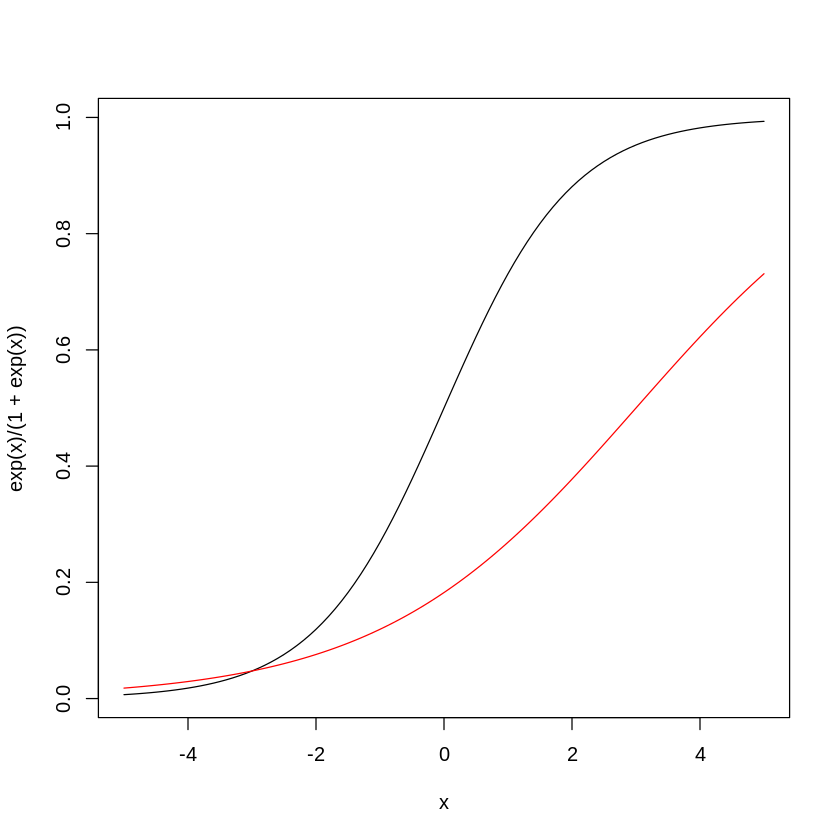

In [10]:
curve(expr = exp(x)/(1+exp(x)), from = -5, to = 5)
curve(expr = exp(-0.5 + 0.5*(x-2))/(1+exp(-0.5 + 0.5*(x-2))), from = -5, to = 5, add = TRUE, col = "red")

Celem jest wylosowanie dwóch prób:

1. próby losowej o liczebności n=1000
2. próby nielosowej według $p_1$ i $p_2$ (uwaga: liczebność próby również będzie zmienną losową)

In [14]:
set.seed(123)
## próbę nielosową
populacja$delta_1 <- rbinom(n = N, prob = populacja$p_1, size = 1) ## rozkład Bernoulliego
populacja$delta_2 <- rbinom(n = N, prob = populacja$p_2, size = 1)

## próbę losową
n <- 1000
sample_ind <- sample(1:nrow(populacja), n)
populacja$ind <- as.integer(populacja$id %in% sample_ind)
head(populacja)

,id,X_1,X_2,Y_1,Y_2,p_1,p_2,delta_1,delta_2,ind
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,0.4395244,1.6399764,3.856908,2.4192128,0.8375317,0.3928873,1,0,0
2,2,0.7698225,0.8362165,2.224028,0.4906076,0.6976678,0.5441835,0,1,0
3,3,2.5587083,0.2214909,3.119574,1.6800052,0.5551475,0.7467867,1,1,0
4,4,1.0705084,0.6128547,3.090614,1.1828452,0.6485917,0.6135089,0,0,0
5,5,1.1292877,0.4650717,4.641065,2.7097784,0.6142166,0.6632927,0,1,0
6,6,2.7150650,1.1759146,5.217566,3.9557575,0.7642124,0.4599754,1,1,0


Na podstawie badania symulacyjnego chcemy określić jakie jest obciążenie estymatora wartości średniej $Y_1$ wyznaczonego na podstawie 3 prób: 2 nielosowych i 1 losowej. 

In [15]:
data.frame("populacja" = mean(populacja$Y_1), 
           "big_data1" = mean(populacja$Y_1[populacja$delta_1 == 1]),
           "big_data2" = mean(populacja$Y_1[populacja$delta_2 == 1]),
           "proba_losowa" = mean(populacja$Y_1[populacja$ind == 1]))

populacja,big_data1,big_data2,proba_losowa
<dbl>,<dbl>,<dbl>,<dbl>
3.000183,3.186211,2.899971,2.954884


Przeprowadzamy badanie symulacyjne, w którym w każdym przebiegu pętli (od 1 do 500) wykonamy następujące kroki:

1. losujemy próbę big data1 ($p_1$)
2. losujemy próbę big data2 ($p_2$)
3. losujemy próbę SRS ($ind$)
4. obliczamy: $\bar{y}_{1,BD1}$, $\bar{y}_{1,BD2}$, $\bar{y}_{1,SRS}$

In [19]:
wyniki <- list()

for (i in 1:500) {
  set.seed(i)
  ## próbę nielosową
  populacja$delta_1 <- rbinom(n = N, prob = populacja$p_1, size = 1) ## rozkład Bernoulliego
  populacja$delta_2 <- rbinom(n = N, prob = populacja$p_2, size = 1)

  ## próbę losową
  n <- 1000
  sample_ind <- sample(1:nrow(populacja), n)
  populacja$ind <- as.integer(populacja$id %in% sample_ind)

  wyniki[[i]] <- data.frame("BD1" = mean(populacja$Y_1[populacja$delta_1 == 1]),
                            "BD2" = mean(populacja$Y_1[populacja$delta_2 == 1]),
                            "SRS" = mean(populacja$Y_1[populacja$ind == 1]))

}


In [23]:
wyniki_df <- do.call("rbind", wyniki)
head(wyniki_df)

,BD1,BD2,SRS
,<dbl>,<dbl>,<dbl>
1,3.187156,2.900651,3.119060
2,3.186537,2.900962,2.960671
3,3.185714,2.901759,2.959227
4,3.186803,2.903106,3.018378
5,3.185601,2.900391,2.977986
6,3.187807,2.900831,3.061523


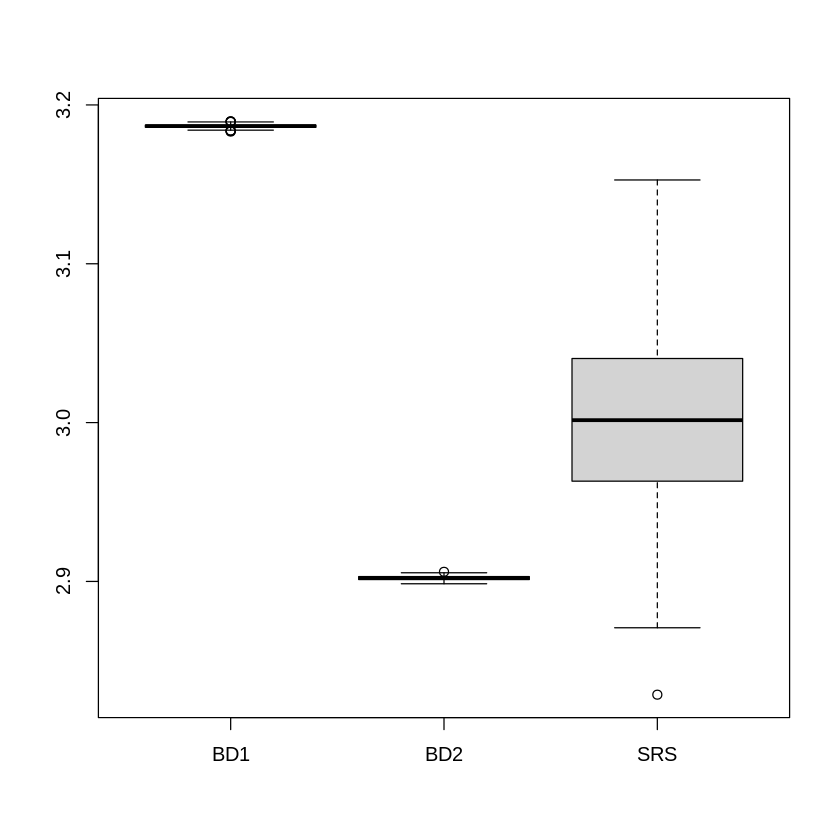

In [24]:
boxplot(wyniki_df)

Liczymy trzy miary jakości:

1. Obciążenie:

$$
Bias(\hat{\theta}_{BD1}) = \bar{\hat{\theta}}_{BD1} - \theta
$$

2. Wariancja

$$
Var(\hat{\theta}_{BD1}) = \sum_i (\hat{\theta}_{BD1} - 
\bar{\hat{\theta}}_{BD1})^2/n
$$

3. MSE

$$
MSE(\hat{\theta}_{BD1}) = Bias(\hat{\theta}_{BD1})^2 + Var(\hat{\theta}_{BD1})
$$


In [27]:
bias_sim <- colMeans(wyniki_df) - mean(populacja$Y_1) ## wzor 1 
var_sim <- sapply(wyniki_df, var) ## wzor 2
mse_sim <- bias_sim^2 + var_sim ## wzor 3

data.frame(estim = c("BD1", "BD2", "SRS"), bias = bias_sim, var = var_sim, mse = mse_sim)

,estim,bias,var,mse
,<chr>,<dbl>,<dbl>,<dbl>
BD1,BD1,0.1864413382,1.101778e-06,0.034761474
BD2,BD2,-0.0980788405,1.686126e-06,0.009621145
SRS,SRS,0.0009558952,2.961441e-03,0.002962354
